Goal: Identify best k using reconstruction error and stability metrics.

Let's identify the top 2-3 values of k using same parameters as SigprofilerExtractor and then do further optimization of other parameters.

SigProfilerExctractor:
"By default, the tool decomposes the input mutation matrix M by searching for an optimal number of mutational signatures, k, ranging from 1 to 25

For each value of k, the tool performs 100 independent NMF factorizations. During each run, the matrix M is first Poisson resampled and normalized. The decomposition is then carried out using the multiplicative update NMF algorithm, minimizing an objective function based on the Kullback-Leibler divergence.

To assess stability, custom partition clustering is applied to the 100 repetitions, using the Hungarian algorithm to compare different solutions. Stable clusters are identified, and their centroids are selected as the optimal signature solutions, ensuring robustness to input noise and the non-uniqueness of NMF."

In [1]:
import os

# change working directory to project-3 root
if os.getcwd().split('/')[-1] != 'project-3':
    os.chdir('../../')

import pandas as pd
import numpy as np
from src.models.nmf_runner import NMFDecomposer
import time
import matplotlib.pyplot as plt
import pickle
from src.models.clustering import consensus_signatures

In [2]:
# set this to True to rerun the NMF
RERUN_NMF = False
APPEND_RESULTS = True # set this to True if you want to append results to existing results

# max K
MAX_K = 15

In [3]:
df_sbs = pd.read_csv('data/processed/BRCA.SBS96.all', sep='\t', index_col=0)
X = np.array(df_sbs)


NMF_PARAMS = {
    'resample_method': 'poisson',
    'objective_function': 'frobenius',
    'initialization_method': 'random',
    'normalization_method': 'GMM',
    'max_iter': 1000000,
    'num_factorizations': 100,
    'random_state': 42,
    'tolerance': 1e-6
}

if RERUN_NMF:

    if APPEND_RESULTS:
        with open('data/nmf_runs/01_nmf_k_selection.runs', 'rb') as f:
            results = pickle.load(f)
            print('Loaded NMF results from file to append NMF runs to', flush=True)
    else:
        results = {}
    start_k = len(results) + 1
    for k in range(start_k,15):
        print(f'Running NMF with k={k}', flush=True)
        NMF_PARAMS['n_components'] = k
        nmf_model = NMFDecomposer(**NMF_PARAMS, verbose=True)
        time_start = time.time()
        S_all, A_all, err_all, n_iter_all = nmf_model.run(X)
        time_end = time.time()
        results[k] = {
            'S_all': S_all,
            'A_all': A_all,
            'err_all': err_all,
            'n_iter_all': n_iter_all,
            'time': time_end - time_start
        }
        with open('data/nmf_runs/01_nmf_k_selection.runs', 'wb') as f:
            pickle.dump(results, f)
else:
    with open('data/nmf_runs/01_nmf_k_selection.runs', 'rb') as f:
        results = pickle.load(f)
        print('Loaded NMF results from file', flush=True)

cleaned_results = {}
for k, res in results.items():
    valid_runs = [
        (S, A, err, n_iter)
        for S, A, err, n_iter in zip(res['S_all'], res['A_all'], res['err_all'], res['n_iter_all'])
        if not (np.isnan(S).any() or np.isnan(A).any())
    ]
    if len(valid_runs) > 0:
        S_all, A_all, err_all, n_iter_all = map(np.array, zip(*valid_runs))
        cleaned_results[k] = {
            'S_all': S_all,
            'A_all': A_all,
            'err_all': err_all,
            'n_iter_all': n_iter_all,
            'time': res['time']
        }
    else:
        print(f"⚠️  No valid runs found for k={k}, skipping entry.")


consensus_results = {}
for k, res in cleaned_results.items():
    if k == 1:
        continue
    S_all = res['S_all']
    centroids_s, sil_score_s = consensus_signatures(X, S_all, k = k, average_threshold=0.8, minimum_threshold=0.2, reconstruction=False)
    consensus_results[k] = {
        'sil_score_s': sil_score_s
    }


Loaded NMF results from file
Cluster 0: avg_sil=0.994, min_sil=0.925
Cluster 1: avg_sil=0.999, min_sil=0.999
2 stable centroids found
Cluster 0: avg_sil=0.965, min_sil=0.890
Cluster 1: avg_sil=0.996, min_sil=0.992
Cluster 2: avg_sil=0.973, min_sil=0.899
3 stable centroids found
Cluster 0: avg_sil=0.878, min_sil=0.557
Cluster 1: avg_sil=0.920, min_sil=0.235
Cluster 2: avg_sil=0.621, min_sil=-0.169
Cluster 3: avg_sil=0.015, min_sil=-0.813
2 stable centroids found
Cluster 0: avg_sil=-0.301, min_sil=-0.793
Cluster 1: avg_sil=0.796, min_sil=0.466
Cluster 2: avg_sil=0.397, min_sil=-0.812
Cluster 3: avg_sil=0.648, min_sil=-0.673
Cluster 4: avg_sil=0.588, min_sil=-0.392
0 stable centroids found
Cluster 0: avg_sil=0.766, min_sil=-0.378
Cluster 1: avg_sil=0.761, min_sil=-0.640
Cluster 2: avg_sil=0.657, min_sil=-0.406
Cluster 3: avg_sil=0.790, min_sil=-0.084
Cluster 4: avg_sil=0.677, min_sil=-0.384
Cluster 5: avg_sil=0.847, min_sil=-0.190
0 stable centroids found
Cluster 0: avg_sil=0.727, min_sil

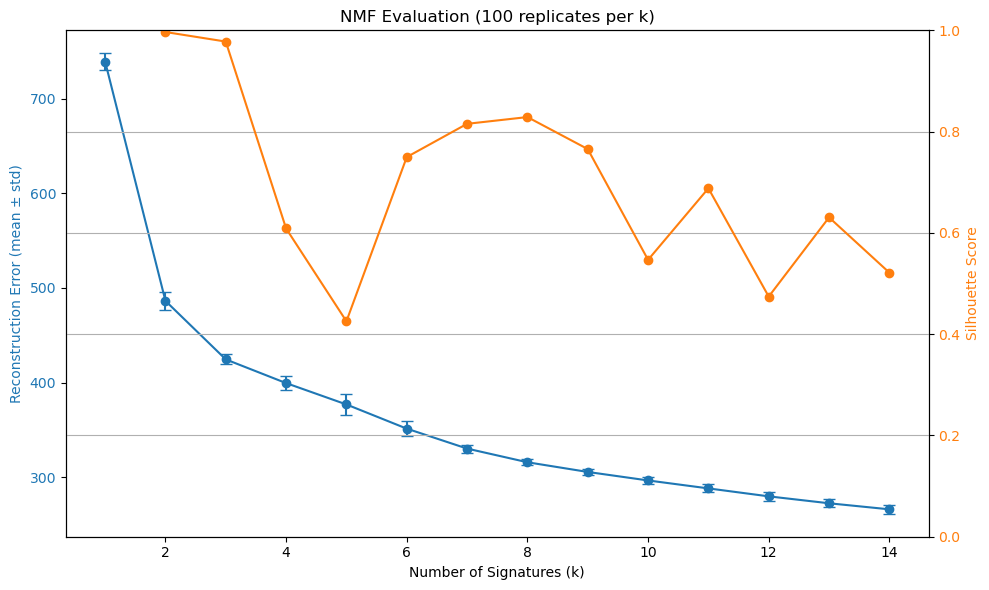

In [4]:
# Extract data
ks = sorted(cleaned_results.keys())
mean_errors = [cleaned_results[k]['err_all'].mean() for k in ks]
std_errors = [cleaned_results[k]['err_all'].std() for k in ks]
sil_scores = [consensus_results[k]['sil_score_s'] for k in ks if k in consensus_results]

# Create plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: reconstruction error
ax1.errorbar(ks, mean_errors, yerr=std_errors, fmt='-o', color='tab:blue', capsize=4, label='Reconstruction Error')
ax1.set_xlabel('Number of Signatures (k)')
ax1.set_ylabel('Reconstruction Error (mean ± std)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right y-axis: silhouette score
ax2 = ax1.twinx()
ax2.plot(ks[1:], sil_scores, marker='o', color='tab:orange', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylim(0, 1)

# Title and layout
plt.title(f'NMF Evaluation ({NMF_PARAMS["num_factorizations"]} replicates per k)')
fig.tight_layout()
plt.grid(True)
plt.show()


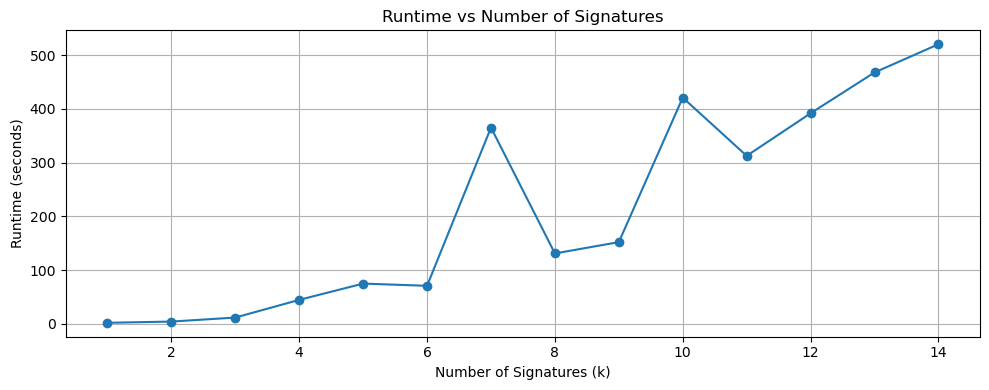

In [5]:
times = [cleaned_results[k]['time'] for k in ks]

plt.figure(figsize=(10, 4))
plt.plot(ks, times, marker='o')
plt.xlabel('Number of Signatures (k)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Number of Signatures')
plt.grid(True)
plt.tight_layout()
plt.show()


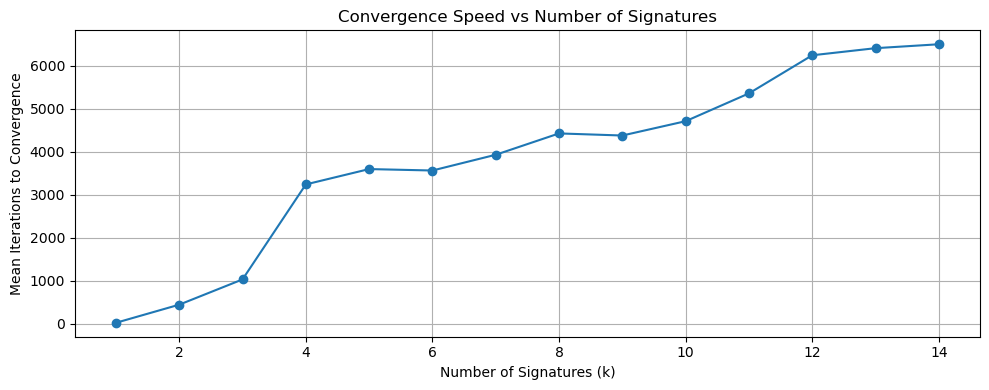

In [6]:
mean_iters = [cleaned_results[k]['n_iter_all'].mean() for k in ks]

plt.figure(figsize=(10, 4))
plt.plot(ks, mean_iters, marker='o')
plt.xlabel('Number of Signatures (k)')
plt.ylabel('Mean Iterations to Convergence')
plt.title('Convergence Speed vs Number of Signatures')
plt.grid(True)
plt.tight_layout()
plt.show()


Choose 2-3 of best k (based on elbow plot and stability of signatures across 100 replicates) and run with more stringent parameters:
- lower tolerance to 1e-8 or 1e-10
- objective_function='kullback-leibler'
- increase max_iter